# Table of contents

[1. Introduction](#Introduction)

[2. Obtaining the data](#Obtaining-the-data)

[3. Scrubbing the data](#Scrubbing-the-data)

[4. SAving the data](#Saving-the-data)

# Introduction

In this file we will split our original datasets into 3 different datasets so that we can apply a stacking method on it.

***
# Obtaining the data

In this section, the data and the required libraries will be imported.

In [1]:
# Importing the required libraries
import pandas as pd
pd.set_option('display.max_columns', 50) # Display up to 50 columns at a time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
plt.style.use('seaborn')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12,5
import glob # To read all csv files in the directory
import seaborn as sns
import calendar
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_fscore_support
import itertools
import time
import xgboost as xgb

The most recent Kickstarter data from https://webrobots.io/kickstarter-datasets/ (from 14 March 2019) is stored in 56 separate csv files. The code below creates a list of all csv files beginning with 'Kickstarter' and concatenates them into one dataframe:

In [2]:
df = pd.concat([pd.read_csv(f) for f in glob.glob('data/Kickstarter*.csv')], ignore_index = True)

***
# Scrubbing the data

In this section the data will be cleaned and pre-processed in order to allow for exploratory data analysis and modeling.

**Inspecting and dropping columns**

In [3]:
# Dropping columns that are mostly null
df.drop(['friends', 'is_backing', 'is_starred', 'permissions'], axis=1, inplace=True)

In [4]:
# Dropping columns that aren't useful
df.drop(['converted_pledged_amount', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'current_currency', 'fx_rate', 'photo', 'pledged', 'profile', 'slug', 'source_url', 'spotlight', 'state_changed_at', 'urls', 'usd_type'], axis=1, inplace=True)

**Converting datetime columns**

Columns containing dates are currently stored in unix time, and need to be converted to datetime. Because they have been converted from unix, all times are in UTC/GMT.

In [5]:
# Converting dates from unix to datetime
cols_to_convert = ['created_at', 'deadline', 'launched_at']
for c in cols_to_convert:
    df[c] = pd.to_datetime(df[c], origin='unix', unit='s')

In [6]:
print(f"The dataset contains projects added to Kickstarter between {min(df.created_at).strftime('%d %B %Y')} and {max(df.created_at).strftime('%d %B %Y')}.")

The dataset contains projects added to Kickstarter between 22 April 2009 and 14 March 2019.


Individual columns will now be pre-processed, and additional features engineered, where necessary.

**Blurb**

Natural language processing is beyond the scope of this project. The length of the blurbs written by project creators will be calculated though, in case this is useful for the model (e.g. people preferring to read shorter or longer blurbs when choosing what to fund). The original blurb variable will then be dropped.

In [7]:
# Count length of each blurb
df['blurb_length'] = df['blurb'].str.split().str.len()

# Drop blurb variable
df.drop('blurb', axis=1, inplace=True)

**Category**

The category variable is currently stored as a string, although it was clearly originally a dictionary. The example below shows that each project has both a category (e.g. games) and a sub-category (e.g. tabletop games). Both will be extracted.

In [8]:
# Example category value
df.iloc[0]['category']

'{"id":266,"name":"Footwear","slug":"fashion/footwear","position":5,"parent_id":9,"color":16752598,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/fashion/footwear"}}}'

In [9]:
# Extracting the relevant sub-category section from the string
f = lambda x: x['category'].split('/')[1].split('","position')[0]
df['sub_category'] = df.apply(f, axis=1)
print(df['category'])

0         {"id":266,"name":"Footwear","slug":"fashion/fo...
1         {"id":273,"name":"Playing Cards","slug":"games...
2         {"id":43,"name":"Rock","slug":"music/rock","po...
3         {"id":273,"name":"Playing Cards","slug":"games...
4         {"id":48,"name":"Nonfiction","slug":"publishin...
                                ...                        
209217    {"id":34,"name":"Tabletop Games","slug":"games...
209218    {"id":38,"name":"Electronic Music","slug":"mus...
209219    {"id":52,"name":"Hardware","slug":"technology/...
209220    {"id":295,"name":"Festivals","slug":"film & vi...
209221    {"id":13,"name":"Journalism","slug":"journalis...
Name: category, Length: 209222, dtype: object


In [10]:
# Extracting the relevant category section from the string, and replacing the original category variable
f = lambda x: x['category'].split('"slug":"')[1].split('","position"')[0].split('/')[0]
df['category'] = df.apply(f, axis=1)
print(df['category'])

0              fashion
1                games
2                music
3                games
4           publishing
              ...     
209217           games
209218           music
209219      technology
209220    film & video
209221      journalism
Name: category, Length: 209222, dtype: object


In [11]:
# Counting the number of unique categories
print(f"There are {df.category.nunique()} unique categories and {df.sub_category.nunique()} unique sub-categories.")

There are 15 unique categories and 145 unique sub-categories.


**Disable_communication**

99.7% of project owners did not disable communication with their backers (unsurprisingly). Because nearly all projects have the same value for this variable, it will be dropped as it does not provide much information.

In [12]:
# Checking the proportions of each category
df.disable_communication.value_counts(normalize=True)

False    0.997022
True     0.002978
Name: disable_communication, dtype: float64

In [13]:
df.drop('disable_communication', axis=1, inplace=True)

**Goal**

The goal amount of funding for each project is currently recorded in native currencies. In order to allow for fair comparisons between projects, goals will be converted into dollars (as amount pledged already is).

In [14]:
# Calculate new column 'usd_goal' as goal * static_usd_rate
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

In [15]:
# Dropping goal and static_usd_rate
df.drop(['goal', 'static_usd_rate'], axis=1, inplace=True)

**Is_starrable**

Only 3.3% of projects were starrable by users. Although this is only a very small proportion, whether or not a project was liked and saved by users is likely to be informative about whether or not a project was successful, so the variable will be kept for now and assessed again once irrelevant rows have been dropped, to check it is still useful.

In [16]:
# Figure out what this is, and do a count_values() to figure out whether it's worth including or mostly FALSE
df.is_starrable.value_counts(normalize=True)

False    0.967403
True     0.032597
Name: is_starrable, dtype: float64

**Location**

The location field contains the town/city that a project originates from, as well as the country. There are a large number (15,235) of unique locations. Because the country is already recorded separately in the country field, and there are such a large number of unique categories (making one-hot encoding not useful, particularly as there are likely to be a lot of smaller towns and cities with very few projects), the column will be dropped.

In [17]:
# Example location value
df.iloc[0]['location']

'{"id":2462429,"name":"Novato","slug":"novato-ca","short_name":"Novato, CA","displayable_name":"Novato, CA","localized_name":"Novato","country":"US","state":"CA","type":"Town","is_root":false,"urls":{"web":{"discover":"https://www.kickstarter.com/discover/places/novato-ca","location":"https://www.kickstarter.com/locations/novato-ca"},"api":{"nearby_projects":"https://api.kickstarter.com/v1/discover?signature=1552595066.49b64db66a5124f5831752d055cd09aff20cc652&woe_id=2462429"}}}'

In [18]:
# Counting the number of unique locations
df.location.nunique()

15235

In [19]:
# Dropping location
df.drop('location', axis=1, inplace=True)

**Name**

The length of project names will be calculated, in case this is useful for the model. The original name variable will then be dropped.

In [20]:
# Count length of each name
df['name_length'] = df['name'].str.split().str.len()
# Drop name variable
df.drop('name', axis=1, inplace=True)

**Usd_pledged**

This column requires rounding to two decimal places.

In [21]:
df['usd_pledged'] = round(df['usd_pledged'],2)

**Additional calculated features**

Additional features can be calculated from the existing features, which may also help to predict whether a project is successfully funded. The features to be added are: time from creation to launch, campaign length, launch day of week, deadline day of week, launch month, deadline month, launch time of day, deadline time of day and mean pledge per backer. Original datetime values and the mean pledge per backer will be kept in for now for EDA purposes, but will be removed later, before modeling.

In [22]:
# Time between creating and launching a project
df['creation_to_launch_days'] = df['launched_at'] - df['created_at']
df['creation_to_launch_days'] = df['creation_to_launch_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only
# Or could show as number of hours:
# df['creation_to_launch_hours'] = df['launched_at'] - df['created_at']
# df['creation_to_launch_hours'] = df['creation_to_launch_hours'].dt.round('h') / np.timedelta64(1, 'h') 

# Campaign length
df['campaign_days'] = df['deadline'] - df['launched_at']
df['campaign_days'] = df['campaign_days'].dt.round('d').dt.days # Rounding to nearest days, then showing as number only

# Launch day of week
df['launch_day'] = df['launched_at'].dt.weekday_name

# Deadline day of week
df['deadline_day'] = df['deadline'].dt.weekday_name

# Launch month
df['launch_month'] = df['launched_at'].dt.month_name()

# Deadline month
df['deadline_month'] = df['deadline'].dt.month_name()

In [23]:
# Launch time
df['launch_hour'] = df['launched_at'].dt.hour # Extracting hour from launched_at

def two_hour_launch(row):
    '''Creates two hour bins from the launch_hour column'''
    if row['launch_hour'] in (0,1):
        return '12am-2am'
    if row['launch_hour'] in (2,3):
        return '2am-4am'
    if row['launch_hour'] in (4,5):
        return '4am-6am'
    if row['launch_hour'] in (6,7):
        return '6am-8am'
    if row['launch_hour'] in (8,9):
        return '8am-10am'
    if row['launch_hour'] in (10,11):
        return '10am-12pm'
    if row['launch_hour'] in (12,13):
        return '12pm-2pm'
    if row['launch_hour'] in (14,15):
        return '2pm-4pm'
    if row['launch_hour'] in (16,17):
        return '4pm-6pm'
    if row['launch_hour'] in (18,19):
        return '6pm-8pm'
    if row['launch_hour'] in (20,21):
        return '8pm-10pm'
    if row['launch_hour'] in (22,23):
        return '10pm-12am'
    
df['launch_time'] = df.apply(two_hour_launch, axis=1) # Calculates bins from launch_time

df.drop('launch_hour', axis=1, inplace=True)

In [24]:
# Deadline time
df['deadline_hour'] = df['deadline'].dt.hour # Extracting hour from deadline

def two_hour_deadline(row):
    '''Creates two hour bins from the deadline_hour column'''
    if row['deadline_hour'] in (0,1):
        return '12am-2am'
    if row['deadline_hour'] in (2,3):
        return '2am-4am'
    if row['deadline_hour'] in (4,5):
        return '4am-6am'
    if row['deadline_hour'] in (6,7):
        return '6am-8am'
    if row['deadline_hour'] in (8,9):
        return '8am-10am'
    if row['deadline_hour'] in (10,11):
        return '10am-12pm'
    if row['deadline_hour'] in (12,13):
        return '12pm-2pm'
    if row['deadline_hour'] in (14,15):
        return '2pm-4pm'
    if row['deadline_hour'] in (16,17):
        return '4pm-6pm'
    if row['deadline_hour'] in (18,19):
        return '6pm-8pm'
    if row['deadline_hour'] in (20,21):
        return '8pm-10pm'
    if row['deadline_hour'] in (22,23):
        return '10pm-12am'
    
df['deadline_time'] = df.apply(two_hour_deadline, axis=1) # Calculates bins from launch_time

df.drop('deadline_hour', axis=1, inplace=True)

In [25]:
# Mean pledge per backer
df['pledge_per_backer'] = round(df['usd_pledged']/df['backers_count'],2)

**Checking for null values**

In [26]:
df.isna().sum()

backers_count                  0
category                       0
country                        0
created_at                     0
deadline                       0
id                             0
is_starrable                   0
launched_at                    0
staff_pick                     0
state                          0
usd_pledged                    0
blurb_length                   8
sub_category                   0
usd_goal                       0
name_length                    0
creation_to_launch_days        0
campaign_days                  0
launch_day                     0
deadline_day                   0
launch_month                   0
deadline_month                 0
launch_time                    0
deadline_time                  0
pledge_per_backer          18362
dtype: int64

There are eight projects without a blurb_length, i.e. without a blurb. These can be replaced with a length of 0.

In [27]:
# Replacing null values for blurb_length with 0
df.blurb_length.fillna(0, inplace=True)

In [28]:
# Confirming there are no null values remaining
df.isna().sum().sum()

18362

**Dropping rows**

This project aims to predict whether projects succeed or fail. The dataset also includes canceled, live (i.e. not yet finished) and suspended projects. These will now be removed.

In [29]:
# Number of projects of different states
df.state.value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

In [30]:
# Dropping projects which are not successes or failures
df = df[df['state'].isin(['successful', 'failed'])]

In [31]:
# Confirming that the most recent deadline is the day on which the data was scraped, i.e. there are no projects which have yet to be resolved into either successes or failures
max(df.deadline)

Timestamp('2019-03-14 04:06:01')

**Dropping duplicates**

As demonstrated above, some projects are included in the dataset more than once. Duplicates will now be assessed and removed.

In [32]:
# Checking for duplicates of individual projects, and sorting by id
duplicates = df[df.duplicated(subset='id')]
print(f"Of the {len(df)} projects in the dataset, there are {len(df[df.duplicated(subset='id')])} which are listed more than once.")
print(f"Of these, {len(df[df.duplicated()])} have every value in common between duplicates.")

Of the 192664 projects in the dataset, there are 23685 which are listed more than once.
Of these, 23674 have every value in common between duplicates.


In [33]:
# Dropping duplicates which have every value in common
df.drop_duplicates(inplace=True)

In [34]:
print(len(df[df.duplicated(subset='id')]), "duplicated projects remain.")
duplicated = df[df.duplicated(subset='id', keep=False)].sort_values(by='id')
duplicated

11 duplicated projects remain.


,backers_count,category,country,created_at,deadline,id,is_starrable,launched_at,staff_pick,state,usd_pledged,blurb_length,sub_category,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer
20854,1675,games,NZ,2018-05-30 04:51:55,2018-12-18 04:00:00,122079667,False,2018-11-21 02:04:29,False,successful,200537.60,12.0,tabletop games,342.10,4,175,27,Wednesday,Tuesday,November,December,2am-4am,4am-6am,119.72
172178,1675,games,NZ,2018-05-30 04:51:55,2018-12-18 04:00:00,122079667,False,2018-11-21 02:04:29,False,successful,200710.36,12.0,tabletop games,342.40,4,175,27,Wednesday,Tuesday,November,December,2am-4am,4am-6am,119.83
118074,32,art,CA,2018-05-07 22:52:48,2018-05-30 01:00:00,123735637,False,2018-05-08 01:43:43,False,successful,669.56,13.0,illustration,466.97,10,0,22,Tuesday,Wednesday,May,May,12am-2am,12am-2am,20.92
160300,32,art,CA,2018-05-07 22:52:48,2018-05-30 01:00:00,123735637,False,2018-05-08 01:43:43,False,successful,669.10,13.0,illustration,466.65,10,0,22,Tuesday,Wednesday,May,May,12am-2am,12am-2am,20.91
124931,18,photography,FR,2017-11-06 23:50:45,2018-01-06 02:53:04,299750696,False,2017-12-02 02:53:04,False,successful,1654.77,18.0,photobooks,1423.46,8,25,35,Saturday,Saturday,December,January,2am-4am,2am-4am,91.93
45253,18,photography,FR,2017-11-06 23:50:45,2018-01-06 02:53:04,299750696,False,2017-12-02 02:53:04,False,successful,1661.61,18.0,photobooks,1429.34,8,25,35,Saturday,Saturday,December,January,2am-4am,2am-4am,92.31
165662,779,games,CA,2018-12-23 02:00:22,2019-03-02 03:00:00,395324593,False,2019-01-29 00:02:43,False,successful,10222.68,17.0,tabletop games,151.33,7,37,32,Tuesday,Saturday,January,March,12am-2am,2am-4am,13.12
122419,779,games,CA,2018-12-23 02:00:22,2019-03-02 03:00:00,395324593,False,2019-01-29 00:02:43,False,successful,10231.08,17.0,tabletop games,151.46,7,37,32,Tuesday,Saturday,January,March,12am-2am,2am-4am,13.13
62993,5,technology,HK,2018-03-15 11:39:29,2018-04-27 02:09:50,1188888346,False,2018-03-28 02:09:50,False,successful,1437.92,20.0,gadgets,1274.30,11,13,30,Wednesday,Friday,March,April,2am-4am,2am-4am,287.58
66791,5,technology,HK,2018-03-15 11:39:29,2018-04-27 02:09:50,1188888346,False,2018-03-28 02:09:50,False,successful,1437.70,20.0,gadgets,1274.10,11,13,30,Wednesday,Friday,March,April,2am-4am,2am-4am,287.54


Comparing rows for each duplicated project:

In [35]:
# Get list of index numbers for duplicated ids
dup_ids = duplicated.id.unique()
for i in dup_ids:
    index1 = duplicated[duplicated.id == i][:1].index.values
    index2 = duplicated[duplicated.id == i][1:2].index.values
    print(index1, index2)
    #print(duplicated.loc[index1] == duplicated.loc[index2]) # produces TypeError: Could not compare [None] with block values

[20854] [172178]
[118074] [160300]
[124931] [45253]
[165662] [122419]
[62993] [66791]
[101074] [34827]
[154822] [14546]
[21153] [40924]
[123041] [132955]
[15470] [146321]
[106904] [207865]


The results above show that for each pair of duplicates, there are differences in the usd_pledge and usd_goal columns. The differences are only in the order of a few cents or dollars, so it does not make much difference which one is kept. Therefore the first one of each pair will be dropped.

In [36]:
df.drop_duplicates(subset='id', keep='first', inplace=True)

**Setting the index**

The id will now be set as the index.

In [37]:
# Setting the id column as the index
df.set_index('id', inplace=True)
df.head()

,backers_count,category,country,created_at,deadline,is_starrable,launched_at,staff_pick,state,usd_pledged,blurb_length,sub_category,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer
id,,,,,,,,,,,,,,,,,,,,,,,
928751314,47,games,US,2017-08-02 14:28:13,2017-09-09 17:00:59,False,2017-08-10 17:00:59,False,successful,1950.00,22.0,playing cards,1000.00,4,8,30,Thursday,Saturday,August,September,4pm-6pm,4pm-6pm,41.49
928014092,271,music,US,2012-09-30 06:45:33,2013-06-12 05:03:15,False,2013-05-13 05:03:15,False,successful,22404.00,15.0,rock,15000.00,7,225,30,Monday,Wednesday,May,June,4am-6am,4am-6am,82.67
596091328,3,games,GB,2017-01-07 09:11:11,2017-03-13 17:22:56,False,2017-01-12 18:22:56,False,failed,165.38,23.0,playing cards,12160.66,8,5,60,Thursday,Monday,January,March,6pm-8pm,4pm-6pm,55.13
998516049,3,publishing,US,2012-12-06 18:04:31,2013-01-09 20:32:07,False,2012-12-10 20:32:07,False,successful,2820.00,24.0,nonfiction,2800.00,7,4,30,Monday,Wednesday,December,January,8pm-10pm,8pm-10pm,940.00
1224600291,35,music,US,2014-10-24 17:35:50,2015-05-02 02:25:46,False,2015-04-02 02:25:46,False,successful,3725.00,18.0,classical music,3500.00,4,159,30,Thursday,Saturday,April,May,2am-4am,2am-4am,106.43


Some features were retained for EDA purposes, but now need to be dropped in order to use machine learning models. This includes datetime features, features that are related to outcomes (e.g. the amount pledged and the number of backers) rather than related to the properties of the project itself (e.g. category, goal, length of campaign), categorical features which would result in too many one-hot encoded features (sub_category), and features that only have one category (is_starrable).

In [38]:
# Dropping columns and creating new dataframe
df_transformed = df.drop(['backers_count', 'created_at', 'deadline', 'is_starrable', 'launched_at', 'usd_pledged', 'sub_category', 'pledge_per_backer'], axis=1)
df_transformed.head()

,category,country,staff_pick,state,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time
id,,,,,,,,,,,,,,,
928751314,games,US,False,successful,22.0,1000.00,4,8,30,Thursday,Saturday,August,September,4pm-6pm,4pm-6pm
928014092,music,US,False,successful,15.0,15000.00,7,225,30,Monday,Wednesday,May,June,4am-6am,4am-6am
596091328,games,GB,False,failed,23.0,12160.66,8,5,60,Thursday,Monday,January,March,6pm-8pm,4pm-6pm
998516049,publishing,US,False,successful,24.0,2800.00,7,4,30,Monday,Wednesday,December,January,8pm-10pm,8pm-10pm
1224600291,music,US,False,successful,18.0,3500.00,4,159,30,Thursday,Saturday,April,May,2am-4am,2am-4am


Multi-collinearity will be checked for by assessing correlations between predictor features, as this can cause issues with some models. The multi-collinearity matrix below shows that this is not an issue:

The dependent variable will now be converted into 1s (successful) and 0s (failure):

In [39]:
df_transformed['state'] = df_transformed['state'].replace({'failed': 0, 'successful': 1})

Categorical features will now be one-hot encoded:

In [40]:
# Converting boolean features to string to include them in one-hot encoding
df_transformed['staff_pick'] = df_transformed['staff_pick'].astype(str)

In [41]:
# Creating dummy variables
df_transformed = pd.get_dummies(df_transformed)

Finally, the dependent (y) and independent (X) features will be separated into separate datasets. Because the features are on different scales, independent features will be transformed and normalised using StandardScaler.

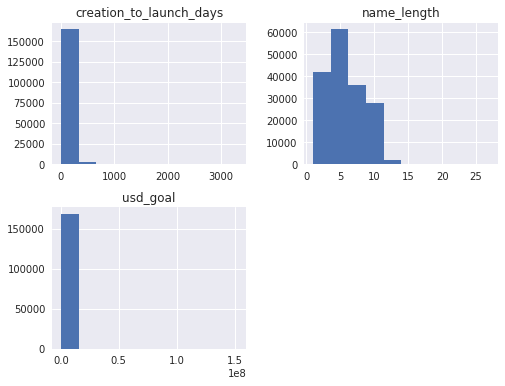

In [42]:
# Assessing skewed distributions
cols_to_log = ['creation_to_launch_days', 'name_length', 'usd_goal']
df_transformed[cols_to_log].hist(figsize=(8,6));

In [43]:
# Replacing 0s with 0.01 and log-transforming
for col in cols_to_log:
    df_transformed[col] = df_transformed[col].astype('float64').replace(0.0, 0.01)
    df_transformed[col] = np.log(df_transformed[col])

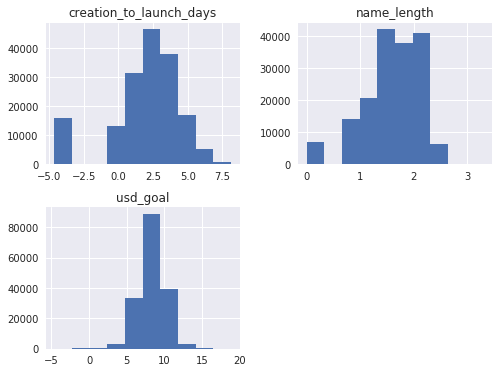

In [44]:
df_transformed[cols_to_log].hist(figsize=(8,6));

Now the data can be prepared again for machine learning by separating X and y, and scaling:

In [45]:
df_transformed.head()

,state,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,category_art,category_comics,category_crafts,category_dance,category_design,category_fashion,category_film & video,category_food,category_games,category_journalism,category_music,category_photography,category_publishing,category_technology,category_theater,country_AT,country_AU,country_BE,country_CA,...,deadline_month_September,launch_time_10am-12pm,launch_time_10pm-12am,launch_time_12am-2am,launch_time_12pm-2pm,launch_time_2am-4am,launch_time_2pm-4pm,launch_time_4am-6am,launch_time_4pm-6pm,launch_time_6am-8am,launch_time_6pm-8pm,launch_time_8am-10am,launch_time_8pm-10pm,deadline_time_10am-12pm,deadline_time_10pm-12am,deadline_time_12am-2am,deadline_time_12pm-2pm,deadline_time_2am-4am,deadline_time_2pm-4pm,deadline_time_4am-6am,deadline_time_4pm-6pm,deadline_time_6am-8am,deadline_time_6pm-8pm,deadline_time_8am-10am,deadline_time_8pm-10pm
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
928751314,1,22.0,6.907755,1.386294,2.079442,30,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
928014092,1,15.0,9.615805,1.945910,5.416100,30,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
596091328,0,23.0,9.405961,2.079442,1.609438,60,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
998516049,1,24.0,7.937375,1.945910,1.386294,30,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
1224600291,1,18.0,8.160518,1.386294,5.068904,30,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [46]:
X_unscaled_log = df_transformed.drop('state', axis=1)
y_log = df_transformed.state

In [47]:
# Transforming the data
scaler = StandardScaler()
X_log = pd.DataFrame(scaler.fit_transform(X_unscaled_log), columns=list(X_unscaled_log.columns))
X_log.head()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,blurb_length,usd_goal,name_length,creation_to_launch_days,campaign_days,category_art,category_comics,category_crafts,category_dance,category_design,category_fashion,category_film & video,category_food,category_games,category_journalism,category_music,category_photography,category_publishing,category_technology,category_theater,country_AT,country_AU,country_BE,country_CA,country_CH,...,deadline_month_September,launch_time_10am-12pm,launch_time_10pm-12am,launch_time_12am-2am,launch_time_12pm-2pm,launch_time_2am-4am,launch_time_2pm-4pm,launch_time_4am-6am,launch_time_4pm-6pm,launch_time_6am-8am,launch_time_6pm-8pm,launch_time_8am-10am,launch_time_8pm-10pm,deadline_time_10am-12pm,deadline_time_10pm-12am,deadline_time_12am-2am,deadline_time_12pm-2pm,deadline_time_2am-4am,deadline_time_2pm-4pm,deadline_time_4am-6am,deadline_time_4pm-6pm,deadline_time_6am-8am,deadline_time_6pm-8pm,deadline_time_8am-10am,deadline_time_8pm-10pm
0,0.599954,-0.863064,-0.369130,0.046185,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,3.839393,-0.14929,-0.412689,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,3.338081,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,-0.235875,2.445936,-0.203413,-0.387776,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,-0.313050,2.662370,-0.24725,-0.36068,-0.180051,-0.352531
1,-0.804977,0.694414,0.596395,1.329281,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,2.423134,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,4.239530,-0.408841,-0.203413,-0.387776,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,3.194373,-0.375605,-0.24725,-0.36068,-0.180051,-0.352531
2,0.800659,0.573727,0.826781,-0.134553,2.325957,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,3.839393,-0.14929,-0.412689,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,-0.235875,-0.408841,-0.203413,2.578810,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,-0.313050,2.662370,-0.24725,-0.36068,-0.180051,-0.352531
3,1.001363,-0.270900,0.596395,-0.220362,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,-0.412689,-0.186654,2.990267,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,-0.259576,-0.367145,-0.235875,-0.408841,-0.203413,-0.387776,-0.191523,2.714977,-0.196596,-0.343587,-0.307077,-0.245277,-0.317588,-0.324195,-0.313050,-0.375605,-0.24725,-0.36068,-0.180051,2.836630
4,-0.202864,-0.142564,-0.369130,1.195768,-0.224741,-0.34594,-0.19773,-0.182523,-0.134647,-0.189923,-0.235358,-0.40577,-0.292264,-0.260458,-0.14929,2.423134,-0.186654,-0.334418,-0.34294,-0.168885,-0.047035,-0.152409,-0.050568,-0.217684,-0.055075,...,-0.299573,-0.208348,-0.338527,-0.298293,-0.275938,3.852439,-0.367145,-0.235875,-0.408841,-0.203413,-0.387776,-0.191523,-0.368327,-0.196596,-0.343587,-0.307077,-0.245277,3.148737,-0.324195,-0.313050,-0.375605,-0.24725,-0.36068,-0.180051,-0.352531


# Saving the data

In [48]:
X_log.to_csv('processed_datasets/observations.csv', header=X_log.columns)
y_log = y_log.values
print(y_log)
y_log = pd.DataFrame(y_log)
print(y_log)
y_log.to_csv('processed_datasets/labels.csv')

[1 1 0 ... 1 1 1]
        0
0       1
1       1
2       0
3       1
4       1
...    ..
168974  1
168975  1
168976  1
168977  1
168978  1

[168979 rows x 1 columns]


Afterwards, we should separate the dataset in three similar subsets for further trainings, validation and tests. More specifically, one part will be used to train the level 0 models, the second part will be used to train the level 1 model and the last subset will be used to test the whole stack.

In [49]:
# Create the different datasets
n_samples = X_log.values.shape[0]
n_subset = n_samples//3
X1 = X_log.iloc[:n_subset,:]
X2 = X_log.iloc[n_subset:2*n_subset,:]
X3 = X_log.iloc[2*n_subset:,:]
y1 = y_log.iloc[:n_subset,:]
y2 = y_log.iloc[n_subset:2*n_subset,:]
y3 = y_log.iloc[2*n_subset:,:];

In [2]:
# Save them into csv files
X1.to_csv('processed_datasets/observations1.csv', header=X1.columns )
X2.to_csv('processed_datasets/observations2.csv', header=X2.columns )
X3.to_csv('processed_datasets/observations3.csv', header=X3.columns )
y1.to_csv('processed_datasets/labels1.csv')
y2.to_csv('processed_datasets/labels2.csv')
y3.to_csv('processed_datasets/labels3.csv')

NameError: name 'X1' is not defined